# Module 01: The K-Armed Bandit Problem

In [1]:
# Modules used in this Notebook
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(6)
np.random.seed(5)

# user-defined functions
import utils

## Sequential Decision Making with Evaluative Feedback

In reinforcement learning, the agent generates its own training data by interacting with the world. The agent must learn the consequences of his own actions through trial and error, rather than being told the correct action. Here, we focus on the problem of decision-making under uncertainty using **k-armed bandits**. 

Imagine a medical trial where a doctor wants to measure the effect of three different treatments (*blue*, *red*, and *green* in the image below). Whenever patient comes into the office, the doctor prescribes a treatment at random. The doctor then monitors the patient and observes any changes to their health (emojis on the right). After a while, the doctor notices that one treatment seems to be working better than the others. The doctor must now decide between sticking with the best-performing treatment or continuing with the randomized study. **If the doctor only prescribes one treatment, then they can no longer collect data on the other two**. Perhaps one of the other treatments is actually better, it only appears worse due to chance. 

<img src="images/k-armed_bandit_medical.svg" width="40%" align="center"/>

If the other two treatments are worse, then continuing the study risk the health of the other patients. This medical trial exemplifies decision-making under uncertainty. The medical trial example is a case of the **k-armed bandit** problem. 

>*In the **k-armed bandit** problem, we have a decision-maker or agent, who chooses between $k$ different actions, and receives a reward based on the action he chooses*.

In the medical trial, the role of the agent is played by a doctor. The doctor has to choose between three different actions, to prescribe the *blue*, *red*, or *green* treatment. Each treatment is an action. Choosing that treatment yields some unknown reward. Finally, the welfare of the patient after the treatment is the reward that the doctor receives. For the doctor to decide which action is best, we must define the *value* of taking each action. We call these values the **action values** or the **action value function**. We can make this definition more precise through the language of probability. 

We define the value of selecting an action as the **expected reward** we receive when taking an action. 

$$
q_{*}(a) \doteq \mathbb{E}[R_t|A_t = a]~~\forall a \in \{1, \cdots, k\}
$$

where $\doteq$ means "*is defined as*". Thus, we can read this equation as $q_{*}(a)$ is defined as the expectation of $R_t$, given we selected action $A$, for each possible action one through $k$. This conditional expectation is defined as a sum over all possible rewards.

$$
q_{*}(a) = \sum_{r} p(r|a)~r
$$

Inside the sum, we have multiplied the possible reward by the probability of observing that reward. This could be extended to the continuous reward case by switching the summation to an integral. 

<font color='#cc0000'>**The goal of the agent is to maximize the expected reward**</font>. If the agent selects the action that has the highest value, it achieves that goal. We call this procedure the **argmax**, or the argument which maximizes our function $q_{*}(a)$. 

$$
\underset{a}{\text{argmax}}~q_{*}(a)
$$

To understand $q_{*}(a)$ better, we said rewards could be the patient's welfare after receiving treatment. But for this example, let's use something which is easier to measure, perhaps the change in blood pressure after receiving the treatment. Each treatment may yield rewards following different probability distributions. For example, *blue* yields a Bernoulli distribution, *red* a binomial distribution, and *green* a uniform distribution, as illustred below. 

<img src="images/k-armed_bandit_reward.svg" width="60%" align="center"/>

$q_{*}(a)$ is the mean of the distributions for each action. We can easily calculate the expected value of the Bernoulli distribution by multiplying the probability of failure by the reward when failed, plus the probability of success, times reward when succeeded.

## Learning Action Values

What would happen if this doctor already knew the long-term outcome of each treatment? Choosing the appropriate treatment would be trivial. Unfortunately, this is often not the case. Usually, the doctor will run many trials to learn about each treatment. Each day, the doctor could use all the previously collected data to estimate which treatment they believed to be the best. 

Remember that the value of an action $q_{*}(a)$ is the expected reward received after that action is taken.

$$
q_{*}(a) \doteq \mathbb{E}[R_t|A_t = a]
$$

As $q_{*}(a)$ is not known to the agent, as the doctor doesn't know the effectiveness of each treatment, we have to estimate it. One way to estimate $q_{*}(a)$ is to compute a **sample-average**. We simply record the total reward for each action and divide it by the number of times that action has been selected. 

$$
Q_t(a) = \frac{\text{sum of rewards when }a\text{ taken prior to }t}{\text{number of times }a\text{ taken prior to }t} = \frac{\sum_{i=1}^{t-1}R_i}{t-1}
$$

We use $t-1$ in the denominator because the value at time $t$ is based on actions taken prior to time $t$. Also, if action $a$ has not yet been taken, we set the value to some default like zero. 

Let's go back to our medical trial example. A doctor must decide which of the three possible treatments to prescribe. If the patient gets better, the doctor records a reward of one. Otherwise, the doctor records a reward of zero. 

$$
\text{reward} = \left\{\begin{matrix}
1 & \text{if succeeds}\\ 
0 & \text{otherwise}
\end{matrix}\right.
$$

To find out the value of $Q_t(a)$, the doctor gives the first patient treatment *blue* on time step one, and the patient reports feeling better. The doctor records a *reward=1* for that treatment and updates the estimate of the value. So far there's only one data point, so the estimated value for treatment *blue* is one. A second patient arrivesand the doctor randomly prescribes treatment *blue* again. It fails, the doctor records and *rewards=0*, and updates the value estimate for treatment *blue* to 0.5. The estimated value for the other actions remain zero since we define the initial estimates to be zero. This process continues up to the last treatment as illustred in the image below. 

<img src="images/greedy_action.gif" width="35%" align="center"/>

After each treatment has been tried a few times, we can calculate the estimated values from the observed data. As the doctor observes more patients, the estimates approach the true action values. In reality, our doctor would not randomly assign treatments to their patients. Instead, they would probably assign the treatment that they currently think is the best. We call this method of choosing actions <font color='#cc0000'>**greedy**</font>. 

> The **greedy action** is the action that currently has the largest estimated value. 

Selecting the **greedy action** means the agent is exploiting its current knowledge. It is trying to get the most reward it can right now. We can compute the greedy action by taking the argmax of our estimated values. 

$$
a_g = \text{argmax}~Q(a)
$$

Alternatively, the agent may choose to **explore** by choosing a non-greedy action. The agent would sacrifice immediate reward hoping to gain more information about the other actions. The agent cannot choose to both **explore** and **exploit** at the same time. This is one of the fundamental problems in reinforced learning. The **exploration-exploitation dilemma**.

## Estimating Action Values Incrementally

Action values can be estimated incrementally for non-stationary problems, *i.e.*, problems that the action value should change according the time passes, or for problems where we do not want to store a large amount of data in order to compute the action values. To do so, we can write the **sample average method** in a recursive manner.

Recall that the sample average method is:

$$
Q_{t}(a) =  \frac{\sum_{i=1}^{t-1}R_i}{t-1}
$$

since before taking an action at time $t$, we consider all the rewards up to time $t-1$. Let's change the equation to consider what action we should take in the step $n+1$, considering that we already have $n$ steps. As $t-1$ converts to $n$, we take it out of the summation for a better understanding, generating:

$$
Q_{n+1} = \frac{1}{n} \sum\limits_{i=1}^{n} R_i
$$

As it is a summation, we can pull the current reward out of the sum, as:

$$
Q_{n+1} = \frac{1}{n} \left(R_n + \sum\limits_{i=1}^{n-1} R_i\right)
$$

We write our next value estimate in terms of our previous value estimate. To do so, we multiply and divide the current sum by $n-1$. By multiplying and dividing by the same thing, we are effectively multiplying by one (but it would make easier to progress). 

$$
Q_{n+1} = \frac{1}{n} \left(R_n + (n-1)\color{brown}{\frac{1}{n-1} \sum\limits_{i=1}^{n-1} R_i}\right)
$$

As we can see, the term in red the definition of $Q_n$, the current value estimate. Changing it in the equation, we have:

$$
Q_{n+1} = \frac{1}{n} \left(R_n + (n-1)~Q_n\right)
$$

We can simplify this equation a little further by distributing $Q_n$ to get this form.

$$
Q_{n+1} = \frac{1}{n} \left(R_n + nQ_n - Q_n\right)
$$

As we have $nQ_n$ in the sum and $\frac{1}{n}$, we pull out the $nQ_n$ and divide it by $\frac{1}{n}$ obtaining:

$$
Q_{n+1} = Q_n + \frac{1}{n} \left(R_n - Q_n\right)
$$

This is the **incremental update rule for estimating values**. This equation is of a form that will show up many times throughout the course. Let's define some of these terms, rewriting it with colors.

$$
Q_{n+1} = Q_n + \color{blue}{\frac{1}{n}} \color{brown}{\left(R_n - Q_n\right)}
$$


The <font color='#cc0000'>**error**</font> in the estimate is the difference between the old estimate and the new target. Taking a step towards that new target will create a new estimate that reduces our error. The new reward ($\color{brown}{R_n}$) is our **target**. The size of the step is determined by our <font color='#2A52BE'>**step size**</font> parameter and the error of our old estimate. 

$$
\text{New estimate} \leftarrow \text{Old estimate} + \text{Step size} (\text{Target} - \text{Old estimate})
$$ 



We now can generate a general rule for updating the estimate incrementally. The <font color='#2A52BE'>**step size**</font> can be a function of $n$ ($\alpha_n$) that produces a number from zero to one.

$$
\alpha_n \rightarrow [0,1]
$$

In the specific case of the **sample average**, the step size is equal to $\alpha_n = \frac{1}{n}$.

Let's go back to the problem of recommending treatments. What if one of the treatments was more effective under certain conditions? Specifically, let's say the treatment B is more effective during the winter months. This is an example of a non-stationary bandit problem. These problems are like the bandit problems, except the distribution of rewards changes with time. The doctor is unaware of this change but would like to adapt to it. One option is to use a fixed step size. If $\alpha_n$ is constant like 0.1, then the most recent rewards affect the estimate more than older rewards.


The graph below shows the amount of weight the most recent award receives versus the reward received $t$ time steps ago. The weighting fades exponentially with time. As we move to the right on the $x$-axis, we go further back in time. 

<img src="images/reward_weight.svg" width="40%" align="center"/>

Let's take a look at the incremental update equation and see why this is true. Let's first distribute $\alpha$ and rearrange it as:

$$
Q_{n+1} = Q_n + \alpha R_n - \alpha Q_n
$$

We can write the next value as a weighted sum of the reward and the last value. 

$$
\begin{matrix}
Q_{n+1} &= \alpha R_n + Q_n - \alpha Q_n\\
        &= \alpha R_n + (1-\alpha)Q_n
\end{matrix}
$$

Notice the recursive form in $Q_n$. We can substitute the definition of $Q_n$ using the equation for $Q_n$ instead of $Q_{n+1}$, as:

$$
Q_{n+1} = \alpha R_n + (1-\alpha) [\alpha R_{n-1} + (1-\alpha)Q_{n-1}]
$$

Then we can distribute $(1 - \alpha)$ and get an equation that shows the relationship between $R_n$ and $R_{n-1}$. 

$$
Q_{n+1} = \alpha R_n + (1-\alpha)\alpha R_{n-1} + (1-\alpha)^2Q_{n-1}
$$

We can unroll this recursive relationship further. We continually replace $Q$ with its definition until we get all the way back to the initial value $Q_1$. 

$$
Q_{n+1} = \alpha R_n + (1-\alpha)\alpha R_{n-1} + (1-\alpha)^2R_{n-2} +\ \ \ \ \cdots \ \ \ \ + (1-\alpha)^{n-1}\alpha R_1 + (1-\alpha)^n Q_1
$$

Finally, let's clean up this long equation. We write it as our initial action value $Q_1$ plus a weighted sum of the rewards over time. 

$$
Q_{n+1} = (1-\alpha)^nQ_1 + \sum\limits_{i=1}^{n} \alpha(1-\alpha)^{n-i}R_i
$$

This equation relates our current estimate of the value $Q_{n+1}$ to $Q_1$ and all the observed rewards. The first term tells us that the contribution of $Q_1$ decreases exponentially with time. The second term tells us the rewards further back in time contribute exponentially less to the sum. Taken all together, we see that the influence of our initialization of $Q$ goes to zero with more and more data. **The most recent rewards contribute most to our current estimate**.

## What is the trade-off?

**Exploration** allows the agent to improve his knowledge about each action, leading to long-term benefit. By improving the accuracy of the estimated action values, the agent can make more informed decisions in the future. 

> **Exploration** improve knowledge about each action for a long-term benefit. 

Let's say each of the plates presented in the image below represents a meal at your favorite restaurant, and you're trying to choose which meal to order. $q(a)$ is the estimated value for picking that meal. $N(a)$ is the number of times you have picked that meal, $q*(a)$ is the value of each meal. Each time you visit this restaurant, you follow a strict regimen and choose each meal in a *Round Robin* fashion, *i.e.*, in equal portions and in circular order, taking all plates without priority. Perhaps a meal is sometimes cooked particularly well. So you are highly rewarded for ordering it (*e.g.*, `+6` for the green plate). After some time, you'll find the best meal to order. 

<img src="images/exploration_reward.gif" width="50%" align="center"/>

**Exploitation** on the other hand, exploits the agent's current estimated values for short-term benefit. It chooses the *greedy action* to try to get the most reward. However, by being greedy with respect to estimated values, it **may not** actually get the most reward.

> **Exploitation** exploits knowledge for short-term benefit.

Let's look at how pure greedy action selection can lead to sub-optimal behavior. Imagine the agents likes the first meal in the image below. The agent received a positive reward making the value for that meal higher. The estimated values for the other actions are zero. So the greedy action is always the same, to pick the first meal. This means the agent never saw any samples for the other meals. The estimated values for the other two actions remain far from the true values, which means the agent never discovered the best action.

<img src="images/exploration_reward.gif" width="50%" align="center"/>

This behaviors introduces the **exploration-exploitation dilemma**. How do we choose when to explore, and when to exploit? When we **explore**, we get more accurate estimates of our values. When we **exploit**, we might get more reward. <font color='#cc0000'>**We cannot however choose to do both simultaneously**</font>. 

One very simple method for choosing between exploration and exploitation is to choose **randomly**. We could choose to exploit most of the time with a small chance of exploring. For instance, we could roll a dice. If it lands on one, then we'll explore. Otherwise, we'll choose the greedy action. We call this method **Epsilon-Greedy**, where 

> **Epsilon** refers to the probability of choosing to explore. 

In the case of rolling a dice, epsilon will be equal to one over six. We can write Epsilon-Greedy in the following way. 

$$
A_t \leftarrow \left\{\begin{eqnarray}
& & \underset{a}{\text{argmax}}~Q_t(a) & \text{with probability}\ \ 1 - \epsilon \\ 
& & a \sim \text{Uniform}(\{a_1 \ \cdots \ a_k\}) & \text{with probability}\ \ \epsilon
\end{eqnarray}\right.
$$

The action that we select on time-step $t$ ($A_t$), is the greedy action with probability ($1-\epsilon$) or is a random action with probability $\epsilon$. 

In [2]:
class EpsilonGreedy(object):
    def __init__(self, nb_arms, epsilon=0.1, alpha=0.1):
        self.Q = [0.]*nb_arms
        self.N = [0]*nb_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.nb_arm = 0
       
    def select_arm(self):
        if random.random() > self.epsilon:
            max_values = np.argwhere(self.Q == np.amax(self.Q)).flatten()
            self.nb_arm = random.choice(max_values)
        else:
            self.nb_arm = random.choice(range(len(self.Q)))
        return self.nb_arm
   
    def update(self, reward):
        self.N[self.nb_arm] += 1
        if self.alpha:
            # non-stationary problem
            alpha = self.alpha
        else:
            # alpha=0 : stationary problem
            alpha = 1. / self.N[self.nb_arm]
        self.Q[self.nb_arm] += alpha * (reward - self.Q[self.nb_arm])
        return self.Q[self.nb_arm]
   
   
class Bandit(object):
    def __init__(self, k):
        self.k = k
        self.dists = []
        self.means = []
        self._generate_distributions()
       
    def _generate_distributions(self, nb_points=2000):
        for i in range(self.k):
            mu = round(random.randint(-1, 1) + random.random(), 2)
            sigma = 1.0
            self.dists.append(np.random.normal(mu, sigma, nb_points))
            self.means.append(mu)

    def pull(self, nb_arm):
        return np.random.choice(self.dists[nb_arm])

Arm with minimum reward: 2
Arm with maximum reward: 0


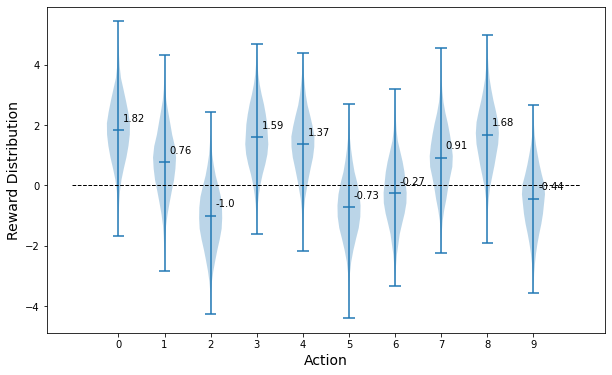

In [3]:
# 10-Armed Bandit
bandit = Bandit(10)
utils.plot_distribution(bandit.dists, bandit.means)

Arm with minimum reward: 2
Arm with maximum reward: 0


<Figure size 432x288 with 0 Axes>

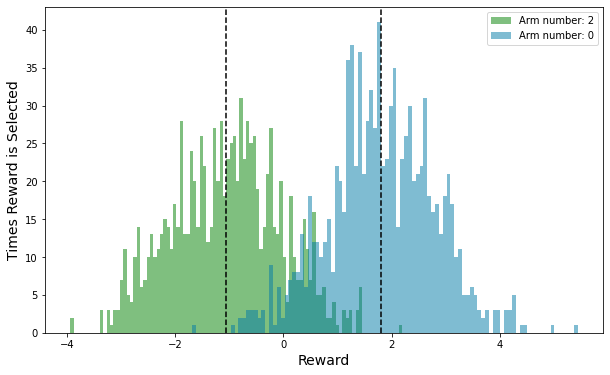

In [4]:
# Test bandit 
minimum_mean = np.argmin(bandit.means)
maximum_mean = np.argmax(bandit.means)
utils.plot_both_distributions(bandit, minimum_mean, maximum_mean)

In [5]:
# Test Epsilon Greedy
values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 455.5]
ground = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 50.5]

# Greedy : Always same arm (we can check it)
greedy = EpsilonGreedy(10, epsilon=0.0, alpha=0)
for i, value in enumerate(values):
    greedy.update(value)
    id_max = np.argmax(greedy.Q)
    assert (greedy.Q[id_max] == ground[i]), str(greedy.Q[id_max])+" != "+str(ground[i])
    assert greedy.N[id_max] == i+1
print('Greedy')
print('------')
print('Rewards Q(a):', greedy.Q)
print('N:', greedy.N)
print('')

# Epsilon Greedy epsilon=1.0: Always random arm (check if it changes)
print('Epsilon Greedy')
print('--------------')
egreedy = EpsilonGreedy(10, epsilon=1.0, alpha=0)
for i, value in enumerate(values):
    egreedy.select_arm()
    egreedy.update(value)
    print('Q: ', egreedy.Q)
    print('N: ', egreedy.N)
    print('')


Greedy
------
Rewards Q(a): [50.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
N: [11, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Epsilon Greedy
--------------
Q:  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
N:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Q:  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0]
N:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

Q:  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 5.0, 0.0, 0.0, 3.0]
N:  [0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

Q:  [0.0, 7.0, 0.0, 0.0, 1.0, 0.0, 5.0, 0.0, 0.0, 3.0]
N:  [0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

Q:  [0.0, 7.0, 0.0, 0.0, 1.0, 0.0, 7.0, 0.0, 0.0, 3.0]
N:  [0, 1, 0, 0, 1, 0, 2, 0, 0, 1]

Q:  [0.0, 7.0, 0.0, 0.0, 1.0, 0.0, 7.0, 11.0, 0.0, 3.0]
N:  [0, 1, 0, 0, 1, 0, 2, 1, 0, 1]

Q:  [0.0, 7.0, 0.0, 13.0, 1.0, 0.0, 7.0, 11.0, 0.0, 3.0]
N:  [0, 1, 0, 1, 1, 0, 2, 1, 0, 1]

Q:  [0.0, 7.0, 0.0, 13.0, 8.0, 0.0, 7.0, 11.0, 0.0, 3.0]
N:  [0, 1, 0, 1, 2, 0, 2, 1, 0, 1]

Q:  [17.0, 7.0, 0.0, 13.0, 8.0, 0.0, 7.0, 11.0, 0.0, 3.0]
N:  [1, 1, 0, 1, 2, 0, 2, 1, 0, 1]

Q:  [17.0, 7.0, 0.0, 16.0, 

In [5]:
# 10-Armed Testbed
class Simulation(object):
    def __init__(self, name, bandit, epsilon, alpha, nb_steps=100, nb_runs=2000):
        self.name = name
        self.bandit = bandit
        self.epsilon = epsilon
        self.alpha = alpha
        self.nb_steps = nb_steps
        self.nb_runs = nb_runs
        self.arms = [-1]*nb_steps
        self.store_acc = []
        self.sum_rewards = [0.]*nb_steps
        self.acc_N = []
        for i in range(len([0]*nb_steps)):
            self.acc_N.append([0]*bandit.k)
        
    def run(self, store=0):
        if store: 
            self.store_acc = [None]*store
            
        for run in range(self.nb_runs):
            self.eg = EpsilonGreedy(bandit.k, epsilon=self.epsilon, alpha=self.alpha)
            rewards = [0]*self.nb_steps
            for step in range(self.nb_steps):
                nb_arm = self.eg.select_arm()
                reward = self.bandit.pull(nb_arm)
                Qa = self.eg.update(reward)
                
                self.arms[step] = nb_arm
                rewards[step] += reward
                self.sum_rewards[step] += reward
                self.acc_N[step][nb_arm] += 1
            if run < store:
                self.store_acc[run] = rewards.copy()
            clear_output(wait=True)
            display('[{}] Reward of run {}: {}'.format(self.name, run, reward))
# End of class Simulation

greedy = Simulation('Greedy', bandit, 0.0, 0.0, nb_steps=1000, nb_runs=2000)
greedy.run(3)
egr001 = Simulation('Epsilon-Greedy=0.01', bandit, 0.01, 0.0, nb_steps=1000, nb_runs=2000)
egr001.run(3)
egr01 = Simulation('Epsilon-Greedy=0.1', bandit, 0.1, 0.0, nb_steps=1000, nb_runs=2000)
egr01.run(3)
print('Simulation completed!')

'[Epsilon-Greedy=0.1] Reward of run 1999: 3.552219095908261'

Simulation completed!


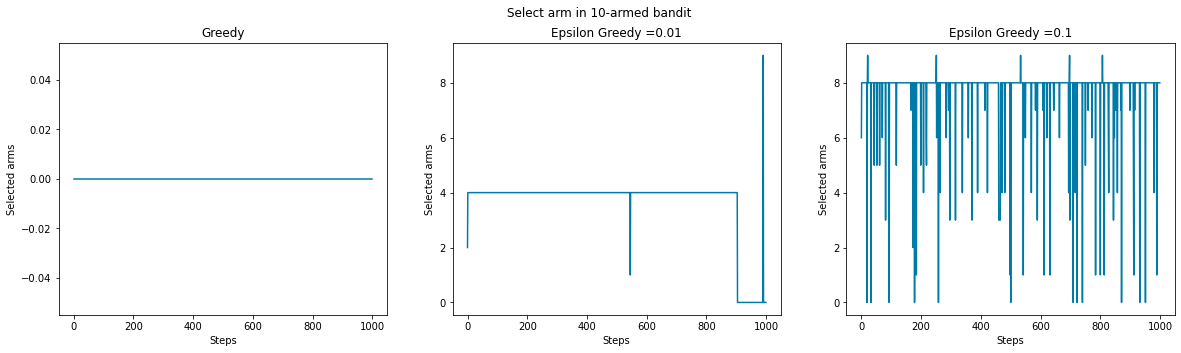

Arm with minimum reward: 3
Arm with maximum reward: 1


In [6]:
# Check selected arms
utils.plot_multiple(greedy.arms, egr001.arms, egr01.arms, 
              'Steps', 'Selected arms', 
              ['Greedy', 'Epsilon Greedy =0.01', 'Epsilon Greedy =0.1'],
              'Select arm in 10-armed bandit')
print('Arm with minimum reward: {}'.format(np.argmin(greedy.bandit.means)+1))
print('Arm with maximum reward: {}'.format(np.argmax(egr001.bandit.means)+1))

<Figure size 432x288 with 0 Axes>

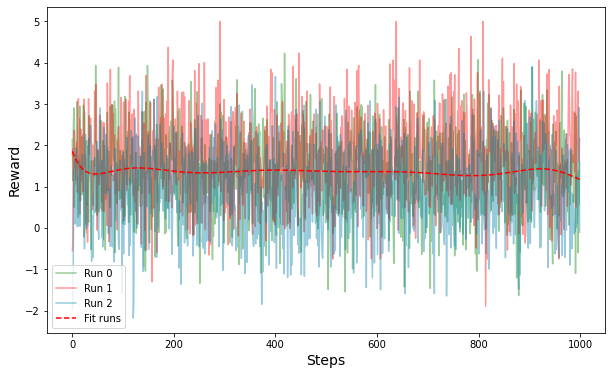

In [7]:
# Check the distribution of rewards for 3 runs
utils.plot_multiple_arms(greedy.store_acc)

<Figure size 432x288 with 0 Axes>

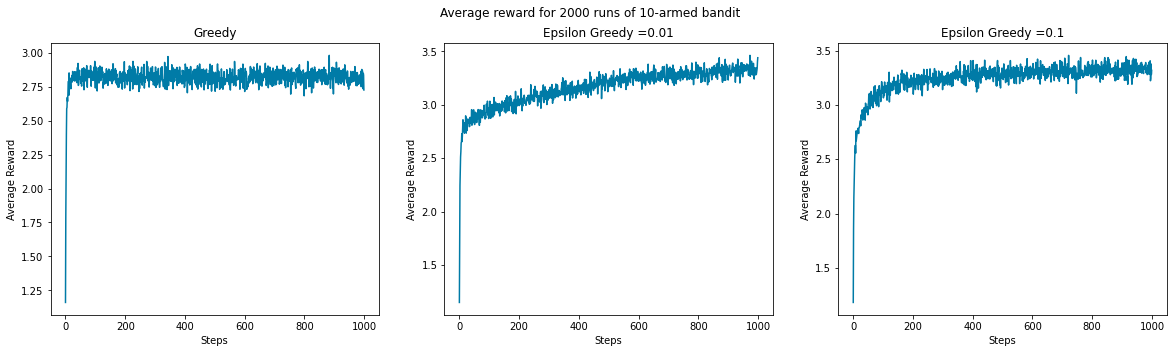

In [8]:
# Average reward for the 2000 runs
utils.plot_average_reward(greedy.sum_rewards, egr001.sum_rewards, egr01.sum_rewards, 
                          ['Greedy', 'Epsilon Greedy =0.01', 'Epsilon Greedy =0.1'], 
                          greedy.nb_runs)

<Figure size 432x288 with 0 Axes>

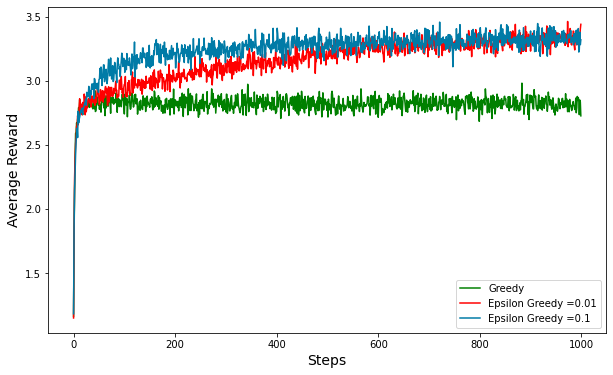

In [10]:
# Compare all average in one plot
utils.plot_average_in_one(greedy.sum_rewards, egr001.sum_rewards, egr01.sum_rewards,
                    ['Greedy', 'Epsilon Greedy =0.01', 'Epsilon Greedy =0.1'])

Arm with minimum reward: 2
Arm with maximum reward: 0


<Figure size 432x288 with 0 Axes>

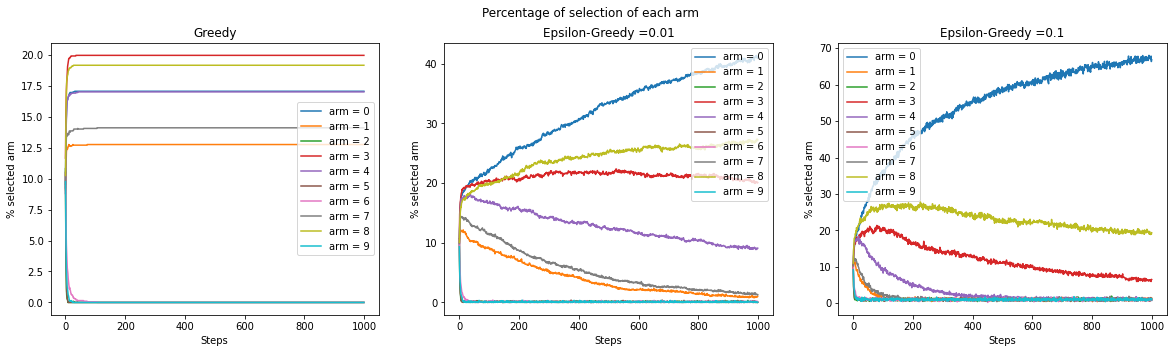

In [11]:
# Plot the percentage of selection of each arm in each step 
utils.plot_distribution_each_arm(bandit, 
                                 [greedy.acc_N, egr001.acc_N, egr01.acc_N], 
                                 greedy.nb_runs, ['Greedy', 'Epsilon-Greedy =0.01', 'Epsilon-Greedy =0.1'], 
                                 'Percentage of selection of each arm')

## Optimistic Initial Values

Let's consider how optimism affects action-selection, using our doctor as an example. Previously the initial estimated values were assumed to be $Q(a)=0$, which is not necessarily optimistic. Now, our doctor optimistically assumes that each treatment is highly effective before running the trial. To make sure we're definitely overestimating, let's make the initial value for each action $Q(a)=0$. Also, let's assume the doctor always chooses the greedy action.

<img src="images/optimistic_initialization.gif" width="40%" align="center"/>

Let's take the $\alpha=0.5$ for this demonstration, where the first patient comes in. Because the values are all equal right now, the doctor chooses a treatment randomly. The doctor prescribes treatment *blue*, and the patient reports feeling better. Notice that the estimated value for treatment *blue* decreased from 2 to 1.5, even though the treatment was a success. *This is because the reward was 1, which is less than our initial optimistic estimate of the value*. The next patient arrives, and the doctor chooses amongst the treatments with the highest estimated value, treatment *red* or treatment *green*. The doctor randomly chooses to prescribe treatment *red*, in which the patient reports that they do not feel better, giving a reward of 0. The doctor lowers their estimated value for treatment *red*. The estimated value decreased to 1, lower than the current estimated value for treatment *blue*. A third patient comes into the clinic, and the doctor prescribes the treatment *green*, since it has the highest estimated value. The patient reports feeling better, so the estimated value only decreases to 1.5. Patients keep coming in, and the doctor continually provides treatments and refines the value estimates.

From this example, we can see that using optimistic initial values encourages exploration early in learning. The doctor tried all three of the treatments in the first three time steps, and continued to try all treatments afterwards. 

Let's use the 10-Armed Testbed using a optimistic initialization. We will use the same previous bandit with the following sampling distribution. 

Arm with minimum reward: 2
Arm with maximum reward: 0


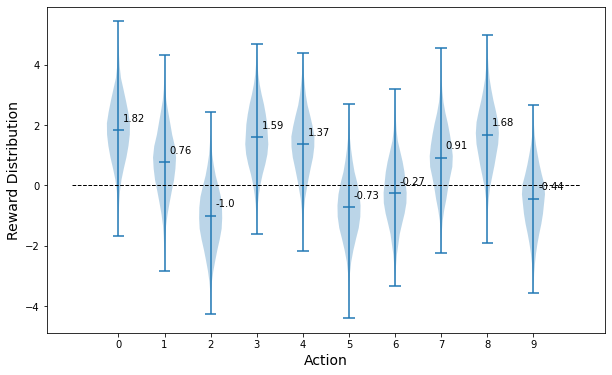

In [12]:
# 10-Armed Bandit
utils.plot_distribution(bandit.dists, bandit.means)

The values for each action are sampled from a normal distribution. For this problem, an initial estimated value of 5 is likely to be optimistic. Whenever the agent selects an action, the first time that action is selected the observed reward will likely be smaller than the optimistic initial estimate. The estimated value for this action will decrease, and other actions will begin to look more appealing in comparison. Let's run an experiment to see how an agent behaves with optimistic initial values. 

As a baseline, we can run an **epsilon greedy** agent with $\epsilon=0.1$, and initial value estimates set to 0 which are not optimistic. We also run a **greedy** agent with optimistic initial values.

In [13]:
class EpsilonGreedy(object):
    def __init__(self, nb_arms, epsilon=0.1, alpha=0.1, init_value=5.0):
        self.Q = [init_value]*nb_arms
        self.N = [0]*nb_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.nb_arm = 0
       
    def select_arm(self):
        if random.random() > self.epsilon:
            max_values = np.argwhere(self.Q == np.amax(self.Q)).flatten()
            self.nb_arm = random.choice(max_values)
        else:
            self.nb_arm = random.choice(range(len(self.Q)))
        return self.nb_arm
   
    def update(self, reward):
        self.N[self.nb_arm] += 1
        if self.alpha:
            # non-stationary problem
            alpha = self.alpha
        else:
            # alpha=0 : stationary problem
            alpha = 1. / self.N[self.nb_arm]
        self.Q[self.nb_arm] += alpha * (reward - self.Q[self.nb_arm])
        #print self.nb_arm, self.N[self.nb_arm], self.Q[self.nb_arm]
        return self.Q[self.nb_arm]
    
class Simulation(object):
    def __init__(self, name, bandit, epsilon, alpha, nb_steps=100, nb_runs=2000, init_value=0.0):
        self.name = name
        self.bandit = bandit
        self.epsilon = epsilon
        self.alpha = alpha
        self.init_value = init_value
        self.nb_steps = nb_steps
        self.nb_runs = nb_runs
        self.sum_rewards = [0.]*nb_steps
        self.acc_N = []
        for i in range(len([0]*nb_steps)):
            self.acc_N.append([0]*bandit.k)
        
    def run(self):
        for run in range(self.nb_runs):
            self.eg = EpsilonGreedy(bandit.k, epsilon=self.epsilon, 
                                    alpha=self.alpha, init_value=self.init_value)
            for step in range(self.nb_steps):
                nb_arm = self.eg.select_arm()
                reward = self.bandit.pull(nb_arm)
                Qa = self.eg.update(reward)
                self.sum_rewards[step] += reward
                self.acc_N[step][nb_arm] += 1
            clear_output(wait=True)
            display('[{}] Reward of run {}: {}'.format(self.name, run, reward))
# End of class Simulation

greedy = Simulation('Greedy (init=0.0)', bandit, 0.0, 0.1, nb_steps=1000, nb_runs=2000, init_value=0.0)
greedy.run()
egreedy = Simulation('Epsilon-Greedy (init=0.0)', bandit, 0.1, 0.1, nb_steps=1000, nb_runs=2000, init_value=0.0)
egreedy.run()
opt_greedy = Simulation('Greedy (init=5.0)', bandit, 0.0, 0.1, nb_steps=1000, nb_runs=2000, init_value=5.0)
opt_greedy.run()
print('Simulation completed!')

'[Greedy (init=5.0)] Reward of run 1999: 1.2018196569261748'

Simulation completed!


<Figure size 432x288 with 0 Axes>

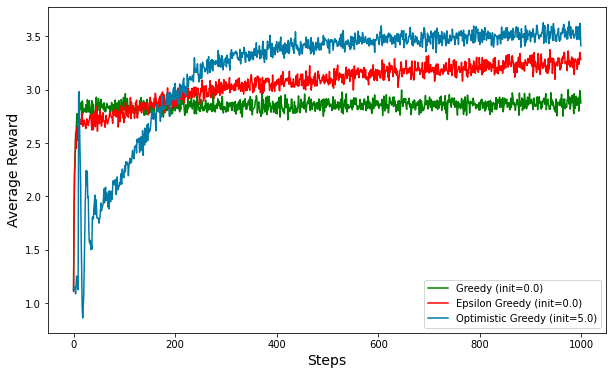

In [18]:
# Plot the average of rewards using an optimistic initialization
utils.plot_average_in_one(greedy.sum_rewards, egreedy.sum_rewards, opt_greedy.sum_rewards,
                    ['Greedy (init=0.0)', 'Epsilon Greedy (init=0.0)', 'Optimistic Greedy (init=5.0)'])

Arm with minimum reward: 2
Arm with maximum reward: 0


<Figure size 432x288 with 0 Axes>

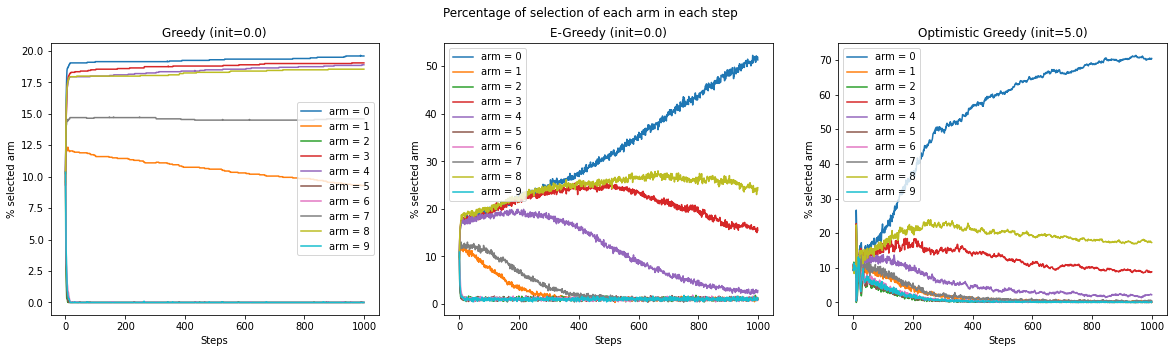

In [20]:
# Plot the percentage of selection of each arm in each step
utils.plot_distribution_each_arm(bandit, [greedy.acc_N, egreedy.acc_N, opt_greedy.acc_N],
                                 egreedy.nb_runs, 
                                 ['Greedy (init=0.0)', 'E-Greedy (init=0.0)', 'Optimistic Greedy (init=5.0)'], 
                                 'Percentage of selection of each arm in each step')

As we can see, in early learning, the optimistic agent performs worse because it explores more. Its exploration decreases with time, because the optimism and its estimates washes out with more samples. Using optimistic initial values is not necessarily the optimal solution for balancing exploration and exploitation. 

> One limitation is that optimistic initial values only drive exploration early in learning, this means agents will not continue exploring after some time.

This leads to issues in non-stationary problems. For example, one of the action values may change after some number of time steps. An optimistic agent may have already settled on a particular action, and will not notice that a different action is better now. Another potential limitation is that we may not always know how to set the optimistic initial values, because in practice we may not know the maximal reward. Regardless of some of these limitations, optimistic initial values has proven to be a very useful heuristic. 

## Upper-Confidence Bound (UCB) Action Selection

Epsilon Greedy uses exploratory actions $\epsilon$ percentage of the time. The exploratory actions are selected uniformly. If we had a notion of uncertainty in our value estimates, we could potentially select actions in a more intelligent way. Consider we have a confidence interval around $Q(a)$ saying that we are confident that the value of action $a$ lies somewhere in this region. For instance, the image below shows a confidence interval for $Q(a)$ represented between brackets. Thus, we believe that the value $q_*(a)$ may be between these brackets, represented as the confidence interval. If this region is very small, such as in (2) in the image below, we are very certain that the value of action $a$ is near our estimated value. If the region is large, such as in (1), we are uncertain that the value of action $a$ is near or estimated value.

<img src="images/confidence_interval.svg" width="40%" align="center"/>

In Upper-Confidence Bound (UCB), we follow the principle of optimism in the face of uncertainty. This simply means that if we are uncertain about something, we should optimistically assume that it is good. For instance, in the image above we have three actions with associated uncertainties, our agent has no idea which is best. So it optimistically picks the action that has the highest upper bound - interval (1). This makes sense because either it does have the highest value and we get good reward, or by taking it we get to learn about an action we know least about. 

Consider we do not have (1) and the algorithm pick one more action. This time (3) has the highest upper-confidence bound because it's estimated value is highest, even though the interval is smaller. We can use upper-confidence bounds to select actions using the following formula:

$$
A \doteq \text{argmax}~\left [ Q_t(a) + \sqrt{\frac{ln~t}{N_t(a)}}~\right ]
$$

where we will select the action that has the highest estimated value ($Q_t(a)$) plus our upper-confidence bound exploration term ($\sqrt{\frac{ln~t}{N_t(a)}}$). The $c$ parameter is a user-specified parameter that controls the amount of exploration. UCB combines exploration and exploitation, since $Q_t(a)$ represents the exploitation part, and the second term represents the exploration part. 

Let's look at a couple of examples of the exploration term. Let's say we've taken 10,000 steps so far. Imagine we've selected action $a$ 5,000 times. The uncertainty term here will be 0.043 times the constant $c$ as shown below:

$$
c~\sqrt{\frac{ln~t}{N_t(a)}} \ \ \ \rightarrow \ \ \ c~\sqrt{\frac{ln~\text{timesteps}}{\text{times action }a\text{ taken}}} \ \ \ \rightarrow \ \ \ c~\sqrt{\frac{ln~10000}{5000}} \ \ \ \rightarrow \ \ \ 0.043c
$$

If instead we had only selected action $a$ 100 times, the uncertainty term would be 10 times larger. 

$$
c~\sqrt{\frac{ln~t}{N_t(a)}} \ \ \ \rightarrow \ \ \ c~\sqrt{\frac{ln~10000}{100}} \ \ \ \rightarrow \ \ \ 0.303c
$$

Let's investigate the performance of upper-confidence bound action selection using the 10-armed Testbed. We will use the same setup as before.

Arm with minimum reward: 2
Arm with maximum reward: 0


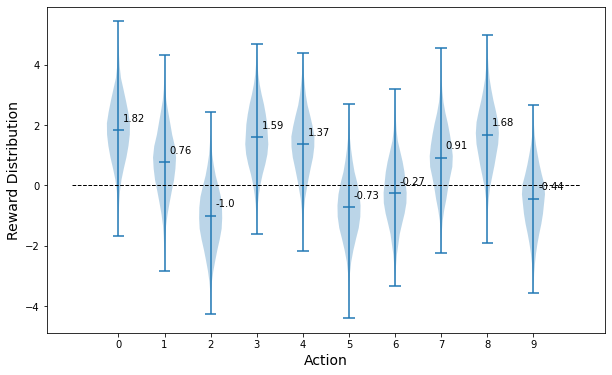

In [22]:
# 10-Armed Bandit
utils.plot_distribution(bandit.dists, bandit.means)

To compare UCB to Epsilon-greedy on the 10-armed bed problem we said $c=2$ for UCB and $\epsilon=0.1$ for Epsilon-greedy. 

In [23]:
class EpsilonGreedy(object):
    def __init__(self, nb_arms, epsilon=0.1, alpha=0.1, init_value=5.0, c=0.0):
        self.Q = [init_value]*nb_arms
        self.N = [0]*nb_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.nb_arm = 0
        self.c = c
        
    def _check_empty(self):
        # Check whether a value is zero
        N = np.sum(self.N) if np.sum(self.N) > 0 else 1.
        Ni = np.array(self.N).copy()
        Ni[Ni==0] = 1
        return N, Ni
        
    def select_arm(self):
        if random.random() > self.epsilon:
            max_values = np.argwhere(self.Q == np.amax(self.Q)).flatten()
            self.nb_arm = random.choice(max_values)
        else:
            if self.c:
                N, Ni = self._check_empty()
                ucb = self.Q + (self.c * np.sqrt(np.log(N)/Ni))
                max_values = np.argwhere(ucb == np.amax(ucb)).flatten()
                self.nb_arm = random.choice(max_values)
            else:
                self.nb_arm = random.choice(range(len(self.Q)))
        return self.nb_arm
   
    def update(self, reward):
        self.N[self.nb_arm] += 1
        if self.alpha:
            # non-stationary problem
            alpha = self.alpha
        else:
            # alpha=0 : stationary problem
            alpha = 1. / self.N[self.nb_arm]
        self.Q[self.nb_arm] += alpha * (reward - self.Q[self.nb_arm])
        return self.Q[self.nb_arm]
    
class Simulation(object):
    def __init__(self, name, bandit, epsilon, alpha, nb_steps=100, nb_runs=2000, init_value=0.0, c=0.0):
        self.name = name
        self.bandit = bandit
        self.epsilon = epsilon
        self.alpha = alpha
        self.init_value = init_value
        self.nb_steps = nb_steps
        self.nb_runs = nb_runs
        self.sum_rewards = [0.]*nb_steps
        self.c = c
        
    def run(self):
        for run in range(self.nb_runs):
            self.eg = EpsilonGreedy(bandit.k, epsilon=self.epsilon, 
                                    alpha=self.alpha, init_value=self.init_value, c=self.c)
            for step in range(self.nb_steps):
                nb_arm = self.eg.select_arm()
                reward = self.bandit.pull(nb_arm)
                Qa = self.eg.update(reward)
                self.sum_rewards[step] += reward
            clear_output(wait=True)
            display('[{}] Reward of run {}: {}'.format(self.name, run, reward))
# End of class Simulation

greedy = Simulation('Greedy (epsilon=0.0)', bandit, 0.0, 0.1, nb_steps=1000, nb_runs=2000, init_value=0.0)
greedy.run()
egreedy = Simulation('Epsilon-Greedy (epsilon=0.1)', bandit, 0.1, 0.0, nb_steps=1000, nb_runs=2000)
egreedy.run()
ubc = Simulation('UBC (c=2.0)', bandit, 1.0, 0.0, nb_steps=1000, nb_runs=2000, c=2.0)
ubc.run()

'[UBC (c=2.0)] Reward of run 1999: 2.9443700459787614'

<Figure size 432x288 with 0 Axes>

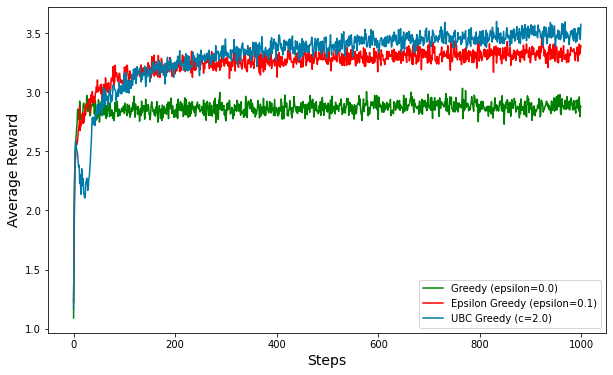

In [27]:
# Plot the average of rewards using UBC with c=2
utils.plot_average_in_one(greedy.sum_rewards, egreedy.sum_rewards, ubc.sum_rewards, 
                          ['Greedy (epsilon=0.0)', 'Epsilon Greedy (epsilon=0.1)', 'UBC Greedy (c=2.0)'])

As we can see, UCB obtains greater reward on average than Epsilon-greedy after about 100 times steps. Initially, UCB explores more to systematically reduce uncertainty. UCB's exploration reduces over time whereas Epsilon-greedy continues to take a random action 10 percent of the time.

## Jonathan Langford: Contextual Bandits for Real World Reinforcement Learning

**Contextual bandits** are the way that reinforcement learning is deployed in the real-world these days. In general, reinforcement is different in simulation and in the real-world. 

> A simulator provides **observations**, and then a learning algorithm has a **policy** which chooses an **action**. The simulator then processes and returns in **reward**. 

When you want to apply this to the real-world, there's a real question about how these things should align. When an **action** is taken based on an **observation**, it differs from simulation because nature of the observation is different, which leads to different **action** even given the same **policy**. The **reward** also is different when you get it from the real-world than to what you get in the simulator. There's is a gap between the simulator and the reality. While you can try to learn in simulators, the applicability of what you've learned in simulators to the real-world applications is unclear and in many cases, maybe even not even possible. So given that there's gap between simulator-based reinforcement learning, which is where much of reinforcement learning is, and real-world-based reinforcement learning, how do you do real-world reinforcement learning? I think the key answer is a shift in priorities. You have to shift your priorities to support real-world reinforcement learning applications. 

For example, *Temporal Credit Assignment* is really important to reinforcement learning, but maybe it's a little less important in the real world. Maybe *generalization* across different observations is more important. In a simulator, it's easy for the reinforcement learning algorithm to *control the environment*. You can say step forward one step please. But in the real-world, typically the *environment controls you*. *Computational efficiency* is the key limiting concern in a simulator because you have as many samples as you can compute. But in the real-world, *statistical efficiency* is the greater concern because you only have the samples that the real-world gives you, and so you must use those samples to achieve the greatest impact that you can. In simulator-based reinforced learning, we have to think about *state*, since it is the fundamental information necessary in order to make a decision. In the real world, often you have some very complex observation which may have much more information that's necessary to make a decision. Thus, it may be important to identify the important *features* of the observation. In the real world, suddenly it becomes important to be able to off policy *evaluation*. In a simulator, there are algorithms which just do *learning*, and the algorithms do learning but also as a byproduct produced it the candidate that you can do a policy evaluation with. Naturally, these policy evaluation supporting algorithms are just preferred for actual applications. In a simulator, maybe you run for a long time and save *last policies* you care about. In the real world, every data point you're gathering involve some interaction with the world, the way you want that performance to be pretty good. So you really care about the *entire trajectory of policies*, the sequence of policies as you're learning in the real world.

| Simulator Environment                                           | Real World Environment         |
| :-------------------------------------------------------------- | :----------------------------- | 
| <font color='#cc0000'>&#9660;</font> Temporal Credit Assignment | <font color='#00ff00'>&#9650;</font> Generalization         |
| <font color='#cc0000'>&#9660;</font> Control Environment        | <font color='#00ff00'>&#9650;</font> Environment Controls   |
| <font color='#cc0000'>&#9660;</font> Computational Efficiency   | <font color='#00ff00'>&#9650;</font> Statistical Efficiency |
| <font color='#cc0000'>&#9660;</font> State                      | <font color='#00ff00'>&#9650;</font> Features               |
| <font color='#cc0000'>&#9660;</font> Learning                   | <font color='#00ff00'>&#9650;</font> Evaluation             |
| <font color='#cc0000'>&#9660;</font> Last Policy                | <font color='#00ff00'>&#9650;</font> Every Policy           |

---
# QUIZ: Exploration/Exploitation

**1. What is the incremental rule (sample average) for action values?**<br>
&#9744; $Q_{n+1} = Q_n + \frac{1}{n} [R_n + Q_n]$<br>
&#9744; $Q_{n+1} = Q_n + \frac{1}{n} [Q_n]$<br>
&#9744; $Q_{n+1} = Q_n - \frac{1}{n} [R_n - Q_n]$<br>
&#9744; $Q_{n+1} = Q_n + \frac{1}{n} [R_n - Q_n]$

Equation 2.5 (from the SB textbook, 2nd edition) is a key update rule we will use throughout the Specialization. We discussed this equation extensively in [video](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/XWqhe/estimating-action-values-incrementally). This exercise will give you a better hands-on feel for how it works. The blue line is the target that we might estimate with equation 2.5. The red line is our estimate plotted over time.
<div class="alert alert-block alert-info"><b>Note:</b> Use this equation in questions (2) to (5)</div>

$$q_{n+1} = q_n + \alpha_n[R_n - q_n]$$

**2. Given the estimate update in red, what do you think was the value of the step size parameter we used to update the estimate on each time step?**

<img src="images/q1-2.png" width="60%" align="center"/>

&#9744; 1.0<br>
&#9744; 1/2<br>
&#9744; 1/8<br>
&#9744; 1/(t-1)

<Figure size 432x288 with 0 Axes>

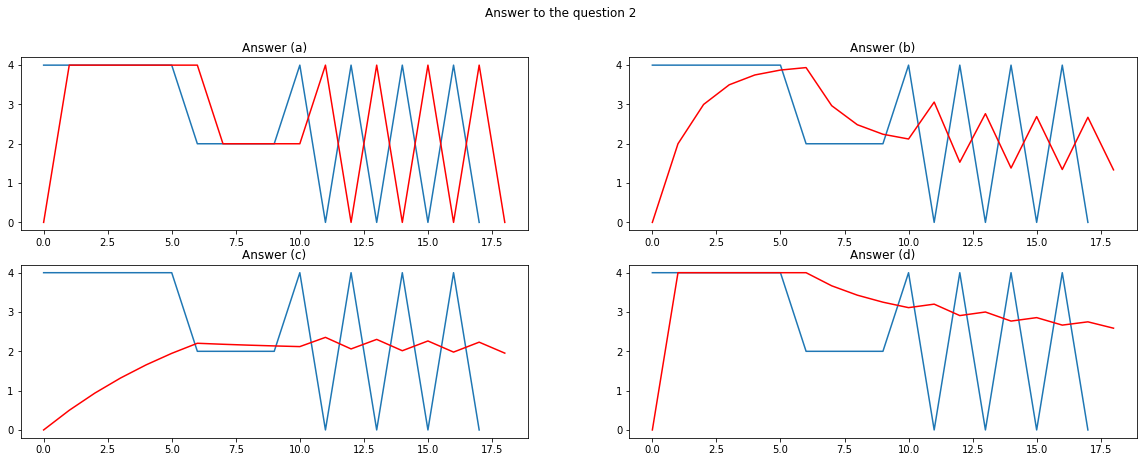

In [10]:
class PseudoEpsilonGreedy(object):
    def __init__(self, alpha):
        self.alpha = alpha
        self.Q = 0.0
        self.index = 1
        
    def update(self, reward):
        if not self.alpha:
            if self.index == 1:
                self.Q = reward
            else:
                self.Q = self.Q + 1./(self.index-1) * (reward - self.Q)
        else:
            self.Q = self.Q + self.alpha * (reward - self.Q)
        self.index += 1
        return self.Q

class PseudoSimulation(object):
    def __init__(self, egreedy, target):
        self.egreedy = egreedy
        self.target = target
        self.rewards = [0.0]
        
    def run(self):
        for t in self.target:
            rwd = self.egreedy.update(t)
            self.rewards.append(rwd)
        return self.rewards
    
target = [4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 0, 4, 0, 4, 0, 4, 0]
# 'd':0 represents 1/(t-1) in PseudoEpsilonGreedy
dquestions = {'a': 1.0, 'b': 0.5, 'c': 0.125, 'd': 0}
drwd = {}
for q in dquestions:
    qa = PseudoSimulation(PseudoEpsilonGreedy(dquestions[q]), target)
    drwd[q] = qa.run()
    
utils.plot_two_columns(target, drwd, 'Answer to the question 2')

**3. Given the estimate update in red, what do you think was the value of the step size parameter we used to update the estimate on each time step?**

<img src="images/q1-3.png" width="60%" align="center"/>

&#9744; 1/(t-1)<br>
&#9744; 1.0<br>
&#9744; 1/2<br>
&#9744; 1/8

**4. Given the estimate update in red, what do you think was the value of the step size parameter we used to update the estimate on each time step?**

<img src="images/q1-4.png" width="60%" align="center"/>

&#9744; 1/(t-1)<br>
&#9744; 1/8<br>
&#9744; 1.0<br>
&#9744; 1/2

**5. Given the estimate update in red, what do you think was the value of the step size parameter we used to update the estimate on each time step?**

<img src="images/q1-5.png" width="60%" align="center"/>

&#9744; 1.0<br>
&#9744; 1/2<br>
&#9744; 1/8<br>
&#9744; 1/(t-1)

**6. What is the exploration/exploitation tradeoff?**

&#9744; The agent wants to explore to get more accurate estimates of its values. The agent also wants to exploit to get more reward. The agent cannot, however, choose to do both simultaneously.<br>
&#9744; The agent wants to maximize the amount of reward it receives over its lifetime. To do so it needs to avoid the action it believes is worst to exploit what it knows about the environment. However to discover which arm is truly worst it needs to explore different actions which potentially will lead it to take the worst action at times.<br>
&#9744; The agent wants to explore the environment to learn as much about it as possible about the various actions. That way once it knows every arm’s true value it can choose the best one for the rest of the time.

**7. Why did epsilon of 0.1 perform better over 1000 steps than epsilon of 0.01?**

<img src="images/q1-78.png" width="80%" align="center"/>

&#9744; The 0.01 agent explored too much causing the arm to choose a bad action too often.<br>
&#9744; Epsilon of 0.1 is the optimal value for epsilon in general.<br>
&#9744; The 0.01 agent did not explore enough. Thus it ended up selecting a suboptimal arm for longer.

**8. If exploration is so great why did epsilon of 0.0 (a greedy agent) perform better than epsilon of 0.4?**

<img src="images/q1-78.png" width="80%" align="center"/>

&#9744; Epsilon of 0.4 explores too often that it takes many sub-optimal actions causing it to do worse over the long term.<br>
&#9744; Epsilon of 0.4 doesn’t explore often enough to find the optimal action.<br>
&#9744; Epsilon of 0.0 is greedy, thus it will always choose the optimal arm.

In [12]:
# Centralize images
from IPython.core.display import HTML
def css_styling():
    styles = open("../_styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()